In [228]:
import numpy as np
import pandas as pd
import glob
import os
import scipy.io
%load_ext autoreload
import process_functions as pf
import matplotlib.pyplot as plt
import scipy
import mne
import pickle

d_path = '/Users/dominicburrows/Dropbox/PhD/Analysis/Project/deep_EEGauditory/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load in data
* EEG dataset from 61 ADHD + 60 control participants
* aged 7-12 yo
* Nasarabadi et al, https://ieee-dataport.org/open-access/eeg-data-adhd-control-children

In [107]:
meta = pd.read_csv(d_path + 'participants.tsv', sep='\t')

#Define key parameters
fs = 500 #sampling rate Hz

In [150]:
meta

,participant_id,Gender,Age,Group,MMSE
0,sub-001,F,57,A,16
1,sub-002,F,78,A,22
2,sub-003,M,70,A,14
3,sub-004,F,67,A,20
4,sub-005,M,70,A,22
...,...,...,...,...,...
83,sub-084,F,71,F,24
84,sub-085,M,64,F,26
85,sub-086,M,49,F,26
86,sub-087,M,73,F,24


In [154]:
#Define key parameters
fs = 500 #sampling rate Hz

# Pre-process data
* Filter & Segment





In [51]:
meta

,participant_id,Gender,Age,Group,MMSE
0,sub-001,F,57,A,16
1,sub-002,F,78,A,22
2,sub-003,M,70,A,14
3,sub-004,F,67,A,20
4,sub-005,M,70,A,22
...,...,...,...,...,...
83,sub-084,F,71,F,24
84,sub-085,M,64,F,26
85,sub-086,M,49,F,26
86,sub-087,M,73,F,24


</Users/dominicburrows/Applications/anaconda3/lib/python3.7/site-packages/decorator.py:decorator-gen-417>:12: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
</Users/dominicburrows/Applications/anaconda3/lib/python3.7/site-packages/decorator.py:decorator-gen-417>:12: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
</Users/dominicburrows/Applications/anaconda3/lib/python3.7/site-packages/decorator.py:decorator-gen-417>:12: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
</Users/dominicburrows/Applications/anaconda3/lib/python3.7/site-packages/decorator.py:decorator-gen-417>:12: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching a

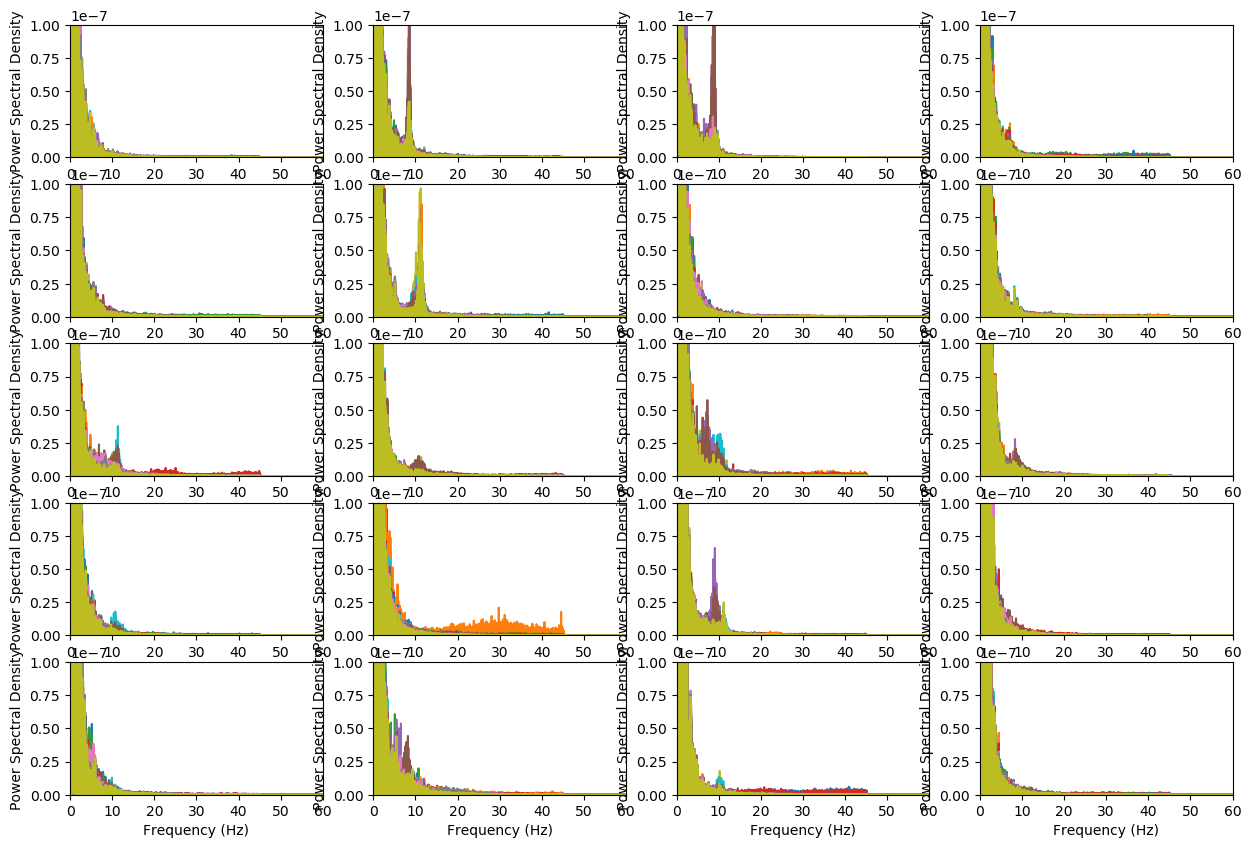

In [154]:
fig, axs = plt.subplots(figsize=(15,10))
#Visualise PSDs 
plot_l = meta[:20]
for m in range(len(plot_l)):
    ax = plt.subplot(5,4,m+1)
    id = meta['participant_id'][m]
    sex = meta['Gender'][m]
    age = meta['Age'][m]
    group = meta['Group'][m]
    mmse = meta['MMSE'][m]
    path = d_path + id + '/eeg/' + id + '_task-eyesclosed_eeg.set'
    
    #Load in
    dic = pf.set_load(path, id, sex, age, group, mmse)
    psd, freq = pf.PSD(dic['data'], fs)
    for i in range(psd.shape[0]):  # Looping through all channels
        ax.plot(freq, psd[i, :], label=f'Channel {i+1}')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power Spectral Density')
    ax.set_xlim(0,60)
    ax.set_ylim(0,0.0000001)
    #plt.legend()
plt.show()


In [222]:
dic

{'id': 'sub-007',
 'sex': 'F',
 'age': 79,
 'group': 'A',
 'mmse': 20,
 'data': array([[3.89530792e-05, 3.94912872e-05, 4.01243324e-05, ...,
         1.36038208e-05, 1.52759628e-05, 1.66538963e-05],
        [3.34050026e-05, 3.43373947e-05, 3.54347878e-05, ...,
         1.65524445e-05, 1.79787331e-05, 1.90138645e-05],
        [3.52346344e-05, 3.56797562e-05, 3.62768364e-05, ...,
         8.89367867e-06, 1.08926001e-05, 1.25999117e-05],
        ...,
        [3.12551098e-05, 3.16739101e-05, 3.23291054e-05, ...,
         1.60055199e-05, 1.68681545e-05, 1.76864281e-05],
        [3.69416313e-05, 3.81921997e-05, 3.94285126e-05, ...,
         3.29313111e-06, 4.73853445e-06, 5.86877680e-06],
        [3.16325455e-05, 3.45591888e-05, 3.73951378e-05, ...,
         7.36533117e-06, 8.05483818e-06, 8.13931656e-06]]),
 'ch_names': ['Fp1',
  'Fp2',
  'F3',
  'F4',
  'C3',
  'C4',
  'P3',
  'P4',
  'O1',
  'O2',
  'F7',
  'F8',
  'T3',
  'T4',
  'T5',
  'T6',
  'Fz',
  'Cz',
  'Pz']}

In [254]:
#===================================================
#Filter out unwanted frequencies, segment and save
#===================================================

#DEFINE PARS
low_f = 50 #freq higher will be removed
high_f = 0.1 #freq lower will be removed
chunk_size = (25*fs) #30 seconds

superid_count, subid_count = 1,1 #define counters for full dataset id and individual id
for m in range(len(meta)):
    subid_count=1
    id = meta['participant_id'][m]
    sex = meta['Gender'][m]
    age = meta['Age'][m]
    group = meta['Group'][m]
    mmse = meta['MMSE'][m]
    path = d_path + 'derivatives/' + id + '/eeg/' + id + '_task-eyesclosed_eeg.set'
    
    #Load in
    dic = pf.set_load(path, id, sex, age, group, mmse)
    raw = dic['data']

    #Apply lowpass filter > 50Hz
    filt = pf.lowpassfilt(raw, low_f, fs)
    #Apply highpass filter < 0.1Hz
    filt = pf.highpassfilt(filt, high_f, fs)
    
    dic['data'] = filt

    #Segment
    bins = pf.split_array_into_bins(dic['data'], chunk_size)

    for b in bins:
        sub_dic={}
        sub_dic['id'] = dic['id']
        sub_dic['sex'] = dic['sex']
        sub_dic['age'] = dic['age']
        sub_dic['group'] = dic['group']
        sub_dic['ch_names'] = dic['ch_names']
        sub_dic['data'] = b
        name = f"""epoch-{superid_count}_{sub_dic['id']}-{subid_count}.pkl""" #give unique identifier and sampleid
        with open(d_path+'/segmented_data/'+name, 'wb') as pickle_file:
            pickle.dump(sub_dic, pickle_file)
        subid_count+=1
        superid_count+=1
    

</Users/dominicburrows/Applications/anaconda3/lib/python3.7/site-packages/decorator.py:decorator-gen-417>:12: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
</Users/dominicburrows/Applications/anaconda3/lib/python3.7/site-packages/decorator.py:decorator-gen-417>:12: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
</Users/dominicburrows/Applications/anaconda3/lib/python3.7/site-packages/decorator.py:decorator-gen-417>:12: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
</Users/dominicburrows/Applications/anaconda3/lib/python3.7/site-packages/decorator.py:decorator-gen-417>:12: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching a